In [155]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
pd.set_option('display.max_columns', None)
# import the required classes and definitions from Python-MIP
from mip import Model, xsum, maximize, BINARY, INTEGER

In [156]:
raw = pd.read_csv('top500histories', index_col=0)
top500_raw = pd.read_csv('top500.csv')

In [157]:
raw.columns

Index(['assists', 'bonus', 'bps', 'clean_sheets', 'creativity', 'element',
       'fixture', 'goals_conceded', 'goals_scored', 'ict_index', 'influence',
       'kickoff_time', 'minutes', 'opponent_team', 'own_goals',
       'penalties_missed', 'penalties_saved', 'red_cards', 'round', 'saves',
       'selected', 'team_a_score', 'team_h_score', 'threat', 'total_points',
       'transfers_balance', 'transfers_in', 'transfers_out', 'value',
       'was_home', 'yellow_cards', 'id_', 'web_name', 'team', 'sum_minutes',
       'sum_points', 'next_week_points', 'team_a_conceded_rank',
       'team_a_conceded_rank_next', 'points_per_90'],
      dtype='object')

In [158]:
 df = top500_raw[['id_', 'web_name', 'team', 'element_type', 'assists', 'bonus', 'bps', 'clean_sheets', 
                 'goals_scored', 'minutes', 'saves', 'total_points',
                 'transfers_in', 'transfers_out']]

In [159]:
histories = raw[['id_', 'web_name', 'value', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 'total_points',
                 'team_a_score', 'team_h_score', 'transfers_in',
                 'transfers_out', 'sum_points', 'sum_minutes', 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'points_per_90', 'next_week_points']]

In [160]:
for gameweek in range(1, max(histories['round'])):
    round_points = histories[histories['round'] == gameweek][['id_', 'total_points']]
    df = df.merge(round_points, on='id_', how='left', suffixes=('', '_' + str(gameweek)))
for gameweek in range(1, max(histories['round'])):    
    round_value = histories[histories['round'] == gameweek][['id_', 'value']].rename(columns={'value':'value_' + str(gameweek)})
    df = df.merge(round_value, on='id_', how='left')
for gameweek in range(1, max(histories['round'])):    
    round_minutes = histories[histories['round'] == gameweek][['id_', 'minutes']].rename(columns={'minutes':'minutes_' + str(gameweek)})
    df = df.merge(round_minutes, on='id_', how='left')

In [161]:
df = df.fillna(0)

In [162]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23
0,215,De Bruyne,11,3,17,20,652,10,7,1890,0,159,4746708,2422150,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2,95.0,95.0,96.0,97.0,98.0,98.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,102.0,103.0,104.0,105.0,106.0,106.0,107,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90
1,166,Vardy,9,4,6,25,553,7,17,1932,0,150,4046382,1844169,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0,90.0,90.0,89.0,89.0,89.0,89.0,89.0,89.0,90.0,91.0,93.0,94.0,96.0,98.0,99.0,100.0,101.0,101.0,101.0,101.0,101.0,100.0,101,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90
2,192,Mané,10,3,8,18,422,9,11,1777,0,147,3607834,2002411,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6.0,11.0,8.0,3.0,3,115.0,115.0,115.0,115.0,115.0,116.0,116.0,116.0,118.0,118.0,119.0,120.0,121.0,122.0,122.0,123.0,123.0,0.0,122.0,122.0,123.0,123.0,124,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90.0,90.0,77.0,80.0,82
3,191,Salah,10,3,5,15,379,11,11,1703,0,135,2219831,2878509,12.0,3.0,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,0.0,3.0,3.0,10.0,6.0,7,125.0,125.0,125.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,122.0,122.0,0.0,122.0,123.0,123.0,123.0,123,90.0,78.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,0.0,69.0,90.0,90.0,90.0,90
4,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2962865,3458978,13.0,6.0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6.0,9.0,2.0,12.0,0,85.0,86.0,87.0,86.0,85.0,85.0,84.0,84.0,84.0,84.0,85.0,85.0,86.0,87.0,87.0,88.0,90.0,91.0,91.0,91.0,91.0,92.0,91,85.0,88.0,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62.0,90.0,90.0,58.0,0


In [163]:
# position lists

keepers = list(df[df.element_type == 1].index)
defenders = list(df[df.element_type == 2].index)
midfielders = list(df[df.element_type == 3].index)
forwards = list(df[df.element_type == 4].index)

# team lists

ars = list(df[df.team == 1].index)
avl = list(df[df.team == 2].index)
bou = list(df[df.team == 3].index)
bha = list(df[df.team == 4].index)
bur = list(df[df.team == 5].index)
che = list(df[df.team == 6].index)
cry = list(df[df.team == 7].index)
eve = list(df[df.team == 8].index)
lei = list(df[df.team == 9].index)
liv = list(df[df.team == 10].index)
mci = list(df[df.team == 11].index)
mun = list(df[df.team == 12].index)
new = list(df[df.team == 13].index)
nor = list(df[df.team == 14].index)
shu = list(df[df.team == 15].index)
sou = list(df[df.team == 16].index)
tot = list(df[df.team == 17].index)
wat = list(df[df.team == 18].index)
whu = list(df[df.team == 19].index)
wol = list(df[df.team == 20].index)

In [164]:
# The selection models

def team_select(profit, weight, df):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = 830
    n = len(weight)

    #create an empty maximization
    m = Model('team_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 11
    m += xsum(df.element_type[i] * x[i] for i in keepers) >= 1 - .1
    m += xsum(df.element_type[i] * x[i] for i in keepers) <= 1 + .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in defenders) <= 10 + .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) >= 6 - .1
    m += xsum(df.element_type[i] * x[i] for i in midfielders) <= 15 + .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) >= 4 - .1
    m += xsum(df.element_type[i] * x[i] for i in forwards) <= 12 + .1

    # max 3 per team

    m += xsum(df.team[i] * x[i] for i in ars) <= 3
    m += xsum(df.team[i] * x[i] for i in avl) <= 6
    m += xsum(df.team[i] * x[i] for i in bou) <= 9
    m += xsum(df.team[i] * x[i] for i in bha) <= 12
    m += xsum(df.team[i] * x[i] for i in bur) <= 15
    m += xsum(df.team[i] * x[i] for i in che) <= 18
    m += xsum(df.team[i] * x[i] for i in cry) <= 21
    m += xsum(df.team[i] * x[i] for i in eve) <= 24
    m += xsum(df.team[i] * x[i] for i in lei) <= 27
    m += xsum(df.team[i] * x[i] for i in liv) <= 30
    m += xsum(df.team[i] * x[i] for i in mci) <= 33
    m += xsum(df.team[i] * x[i] for i in mun) <= 36
    m += xsum(df.team[i] * x[i] for i in new) <= 39
    m += xsum(df.team[i] * x[i] for i in nor) <= 42
    m += xsum(df.team[i] * x[i] for i in shu) <= 45
    m += xsum(df.team[i] * x[i] for i in sou) <= 48
    m += xsum(df.team[i] * x[i] for i in tot) <= 51
    m += xsum(df.team[i] * x[i] for i in wat) <= 54
    m += xsum(df.team[i] * x[i] for i in whu) <= 57
    m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    dream_team = df.iloc[selected,:].sort_values('element_type')
    return dream_team

In [165]:
def bench_select(profit, weight, formation, budget, data):

    # define the problem data, change the profit list here
    # profit = 
    # weight = 
    c = budget
    n = len(weight)

    #create an empty maximization
    m = Model('bench_select')

    #add the binary decision variables to model m and store their references in a list x
    x = [m.add_var(var_type=BINARY) for i in range(n)]

    #define the objective function of this model 
    m.objective = maximize(xsum(profit[i] * x[i] for i in range(n)))

    #add the capacity constraints
    m += xsum(weight[i] * x[i] for i in range(n)) <= c
    m += xsum(x) <= 4.1
    m += xsum(data.element_type[i] * x[i] for i in keepers) >= .9
    m += xsum(data.element_type[i] * x[i] for i in keepers) <= 1.1
    m += xsum(data.element_type[i] * x[i] for i in defenders) >= 2 * formation[1] - .1
    m += xsum(data.element_type[i] * x[i] for i in defenders) <= 2 * formation[1] + .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) >= 3 * formation[2] - .1
    m += xsum(data.element_type[i] * x[i] for i in midfielders) <= 3 * formation[2] + .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) >= 4 * formation[3] - .1
    m += xsum(data.element_type[i] * x[i] for i in forwards) <= 4 * formation[3] + .1

    # max 3 per team

#     m += xsum(df.team[i] * x[i] for i in ars) <= 3
#     m += xsum(df.team[i] * x[i] for i in avl) <= 6
#     m += xsum(df.team[i] * x[i] for i in bou) <= 9
#     m += xsum(df.team[i] * x[i] for i in bha) <= 12
#     m += xsum(df.team[i] * x[i] for i in bur) <= 15
#     m += xsum(df.team[i] * x[i] for i in che) <= 18
#     m += xsum(df.team[i] * x[i] for i in cry) <= 21
#     m += xsum(df.team[i] * x[i] for i in eve) <= 24
#     m += xsum(df.team[i] * x[i] for i in lei) <= 27
#     m += xsum(df.team[i] * x[i] for i in liv) <= 30
#     m += xsum(df.team[i] * x[i] for i in mci) <= 33
#     m += xsum(df.team[i] * x[i] for i in mun) <= 36
#     m += xsum(df.team[i] * x[i] for i in new) <= 39
#     m += xsum(df.team[i] * x[i] for i in nor) <= 42
#     m += xsum(df.team[i] * x[i] for i in shu) <= 45
#     m += xsum(df.team[i] * x[i] for i in sou) <= 48
#     m += xsum(df.team[i] * x[i] for i in tot) <= 51
#     m += xsum(df.team[i] * x[i] for i in wat) <= 54
#     m += xsum(df.team[i] * x[i] for i in whu) <= 57
#     m += xsum(df.team[i] * x[i] for i in wol) <= 60

    #Optimize the model
    m.optimize()

    # Compute the solution, a list of the selected items
    selected = [i for i in range(n) if x[i].x >= 0.99]
    # print('selected items: {}'.format(selected))
    bench = data.iloc[selected,:].sort_values('element_type')
    return bench

In [166]:
mic = [91, 62, 52, 50, 74,
       71, 53, 50, 32, 77,
       85, 67, 86, 59, 50,
       71, 66, 43, 43, 58,
       61, 82, 42]

In [167]:
cooper = [83, 57, 57, 70, 58, 
          73, 52, 43, 32, 61, 
          74, 80, 58, 51, 55, 
          67, 65, 42, 28, 59, 
          54, 60, 45]

In [168]:
scout = [88, 65, 55, 64, 37, 
         90, 44, 36, 46, 51, 
         41, 87, 78, 56, 62, 
         65, 62, 28, 44, 53, 
         53, 58, 37]

In [169]:
global_ave = [65, 41, 44, 57, 52, 
              52, 51, 36, 37, 49,
              53, 48, 49, 51, 49,
              54, 56, 38, 49, 54,
              48, 57, 44]

In [170]:
top_10k_ave = [0.0, 0.0, 45.3, 54.5, 52.1,
             57.0, 50.8, 38.0, 35.9, 55.7,
             64.6, 65.5, 63.2, 50.3, 58.2,
             62.8, 61.6, 45.0, 53.0, 59.3,
             52.1, 60.1, 44.9]

In [171]:
team_points = pd.DataFrame({'scout':scout, 'mic':mic, 'cooper':cooper, 'top_10k':top_10k_ave, 'overall':global_ave})

In [172]:
team_points

,scout,mic,cooper,top_10k,overall
0,88,91,83,0.0,65
1,65,62,57,0.0,41
2,55,52,57,45.3,44
3,64,50,70,54.5,57
4,37,74,58,52.1,52
5,90,71,73,57.0,52
6,44,53,52,50.8,51
7,36,50,43,38.0,36
8,46,32,32,35.9,37
9,51,77,61,55.7,49


In [173]:
team_points['baseline'] = 0

In [174]:
team_points.head()

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0
1,65,62,57,0.0,41,0
2,55,52,57,45.3,44,0
3,64,50,70,54.5,57,0
4,37,74,58,52.1,52,0


In [175]:
number_of_alerts_baseline = 0
number_of_alerts_linear = 0
number_of_alerts_forest = 0

In [176]:

for i in range(2, len(team_points.index)):
    dream_team = team_select(df['total_points_'+ str(i)], df['value_'+ str(i)], df)
    next_week_points = dream_team['total_points_' + str(i + 1)]
    next_week_minutes = dream_team['minutes_' + str(i + 1)]
    print(dream_team[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'value_' + str(i)] = 1000


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    print(dream_team_formation)
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['total_points_' + str(i)],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
#     print(bench[['total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['total_points_' + str(i)], ascending=False)
    print(bench_field[['total_points_' + str(i), 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])
    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    

    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)   

    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)
    
    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_baseline = number_of_alerts_baseline + 1
    
    
#     for id_ in bench_field['id_']:
#         player = bench_field[bench_field['id_'] == id_]
#         if number_of_benched == 0:
#             break
#         else:
#     for j in range(number_of_benched):
                            
#         potential_formation = dream_team_played_formation
#         potential_formation.loc[player['element_type']] = potential_formation.loc[player['element_type']] + 1
                
                
#             if (int(player['minutes_' + str(i + 1)]) > 0 and
#                     potential_formation.loc[2] >= 3 and
#                     potential_formation.loc[2] <= 5 and
#                     potential_formation.loc[3] >= 2 and
#                     potential_formation.loc[3] <= 5 and
#                     potential_formation.loc[4] >= 1 and
#                     potential_formation.loc[4] <= 5):
#                 bench_points = bench_points + int(player['total_points_' + str(i + 1)])
#                 dream_team_played_formation = potential_formation
    
#         number_of_benched = number_of_benched - 1
        
    print('bench points: ', bench_points)

                
 
    
    captain = dream_team['total_points_' + str(i)].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points.baseline.loc[i] = final_points
    # adding the 'captain' points based on highest scoring player the previous week
   

     total_points_3   web_name  team  minutes_3
24              1.0  Henderson    15       90.0
20              0.0  Lundstram    15       90.0
36              1.0    Stevens    15       90.0
55              1.0      Digne     8       90.0
0               5.0  De Bruyne    11       90.0
2               3.0       Mané    10       76.0
166             2.0    Bernard     8       61.0
206             2.0     Lamela    17       61.0
277             2.0   Ceballos     1       60.0
11             11.0      Pukki    14       90.0
109             1.0  Lacazette     1        9.0
dream team cost:  746.0
bench budget:  254.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  210.0
     total_points_2  total_points_3    web_name  team  minutes_3
375             8.0             0.0  Chicharito    19        0.0
157             7.0             1.0        Mina     8       90.0
80              6.0             1.0      Basham    15       77.0
1    1
2    3
3    5
4    2
dtype: int6

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_4     web_name  team  minutes_4
268             5.0         Gunn    16       90.0
140             6.0  van Aanholt     7       90.0
220            11.0  Vestergaard    16       90.0
244             2.0       Engels     2       90.0
259             6.0        Matip    10       90.0
3               6.0        Salah    10       90.0
41             10.0  David Silva    11       77.0
85              0.0      Redmond    16        0.0
7              13.0      Abraham     6       83.0
10             16.0       Agüero    11       90.0
53              8.0       Haller    19       90.0
dream team cost:  777.0
bench budget:  223.0
1    1
2    4
3    3
4    3
Name: element_type, dtype: int64
bench cost:  206.0
     total_points_3  total_points_4 web_name  team  minutes_4
74              9.0             3.0    Noble    19       84.0
158             8.0             8.0    Schär    13       84.0
39              8.0             2.0    Mount     6       90.0
1    1
2    4
3    2
4    3

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_5          web_name  team  minutes_5
179            10.0         Fabianski    19       90.0
5               2.0  Alexander-Arnold    10       90.0
220             5.0       Vestergaard    16       90.0
302             3.0           Masuaku    19       66.0
0               1.0         De Bruyne    11       33.0
18              4.0       Richarlison     8       80.0
60              2.0         Tielemans     9       90.0
250             1.0   Callum Robinson    15        6.0
1               2.0             Vardy     9       90.0
7              14.0           Abraham     6       76.0
10              6.0            Agüero    11       90.0
dream team cost:  788.0
bench budget:  212.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  190.0
     total_points_4  total_points_5 web_name  team  minutes_5
203            10.0             2.0   Hughes    18       62.0
209             8.0            -1.0     Ward     7       90.0
232             8.0          

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_6       web_name  team  minutes_6
179             8.0      Fabianski    19       90.0
83              1.0         Aurier    17       90.0
146             1.0   Alderweireld    17       90.0
177             0.0         Tomori     6       90.0
2               2.0           Mané    10       70.0
25              5.0            Son    17       90.0
76              2.0        Buendía    14       90.0
251             0.0        Djenepo    16        0.0
7               2.0        Abraham     6       76.0
8               5.0     Aubameyang     1       90.0
61              7.0  Callum Wilson     3       90.0
dream team cost:  783.0
bench budget:  217.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  193.0
     total_points_5  total_points_6    web_name  team  minutes_6
311             9.0             0.0       March     4        0.0
123             8.0             1.0    Lindelöf    12       90.0
133             8.0             6.0  Fredericks    19   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_7        web_name  team  minutes_7
48              2.0        Ramsdale     3       90.0
20              2.0       Lundstram    15       90.0
21             13.0         Pereira     9       90.0
131             7.0       Cresswell    19       90.0
132             1.0        Otamendi    11       90.0
0               9.0       De Bruyne    11       79.0
16              0.0        Maddison     9        0.0
71              1.0  Bernardo Silva    11       10.0
107             8.0          McGinn     2       90.0
168             9.0      Yarmolenko    19       90.0
31              7.0            Wood     5       90.0
dream team cost:  676.0
bench budget:  324.0
1    1
2    4
3    5
4    1
Name: element_type, dtype: int64
bench cost:  247.0
     total_points_6  total_points_7 web_name  team  minutes_7
17              9.0             2.0  Firmino    10       86.0
145             9.0             0.0     Jota    20        0.0
151             8.0             0.0  Webster     4   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_8     web_name  team  minutes_8
51              6.0     Patrício    20       90.0
21              1.0      Pereira     9       90.0
38              0.0        Evans     9       90.0
66              1.0      Doherty    20       22.0
15              1.0       Mahrez    11       59.0
30              8.0      Willian     6       90.0
72              1.0     Jorginho     6       90.0
94              3.0    Wijnaldum    10       77.0
115             0.0  Milivojevic     7        0.0
1               2.0        Vardy     9       90.0
120             2.0         King     3       90.0
dream team cost:  699.0
bench budget:  301.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  208.0
     total_points_7  total_points_8 web_name  team  minutes_8
126             9.0             5.0  Targett     2       90.0
259             9.0             0.0    Matip    10        0.0
9               9.0             7.0     Ings    16       80.0
1    1
2    3
3    4
4    2

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_9    web_name  team  minutes_9
29              2.0      Foster    18       90.0
62              1.0        Dunk     4       90.0
96              2.0     Willems    13       90.0
147             2.0  David Luiz     1       90.0
2               2.0        Mané    10       90.0
27              2.0      Traoré    20       90.0
163             1.0   Hourihane     2       62.0
197             0.0      Milner    10        0.0
6               7.0     Jiménez    20       90.0
88              2.0      Wesley     2       75.0
211             1.0    Connolly     4       45.0
dream team cost:  650.0
bench budget:  350.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  178.0
     total_points_8  total_points_9           web_name  team  minutes_9
291            10.0             2.0  Matthew Longstaff    13       90.0
54              9.0             1.0          Tarkowski     5       90.0
228             9.0            12.0            Janmaat    18       70.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_10     web_name  team  minutes_10
70               1.0     Pickford     8        90.0
59               2.0    O'Connell    15        90.0
126              1.0      Targett     2        90.0
180              6.0       Alonso     6        62.0
228              6.0      Janmaat    18        90.0
19               1.0     Grealish     2        83.0
41               9.0  David Silva    11        90.0
57               9.0       Barnes     9        71.0
75               2.0     Doucouré    18        90.0
166              1.0      Bernard     8        29.0
4                9.0     Rashford    12        90.0
dream team cost:  649.0
bench budget:  351.0
1    1
2    4
3    5
4    1
Name: element_type, dtype: int64
bench cost:  244.0
     total_points_9  total_points_10    web_name  team  minutes_10
189             9.0              6.0  Steve Cook     3        90.0
9               9.0              1.0        Ings    16        45.0
1               8.0             20.0       Vardy  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_11     web_name  team  minutes_11
90               2.0         Krul    14        90.0
64               6.0     Chilwell     9        90.0
128              2.0        Jonny    20        90.0
186              1.0    Lascelles    13        90.0
12               1.0     Sterling    11        90.0
23               3.0        Pérez     9        73.0
30               2.0      Willian     6        90.0
82               9.0      Pulisic     6        82.0
115              2.0  Milivojevic     7        90.0
1                6.0        Vardy     9        90.0
42               2.0       Maupay     4        90.0
dream team cost:  737.0
bench budget:  263.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  225.0
     total_points_10  total_points_11   web_name  team  minutes_11
4                9.0              2.0   Rashford    12        90.0
121              8.0              6.0  Fernández    13        90.0
136              8.0              6.0        Aké  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_12    web_name  team  minutes_12
48               4.0    Ramsdale     3        90.0
20               2.0   Lundstram    15        90.0
47               8.0     Söyüncü     9        90.0
108              1.0      Walker    11        90.0
154             -1.0     Montoya     4        45.0
238              1.0  Adam Smith     3        77.0
2                7.0        Mané    10        90.0
16               9.0    Maddison     9        90.0
92               1.0    Trossard     4        59.0
7                8.0     Abraham     6        72.0
86               2.0     Mousset    15        87.0
dream team cost:  663.0
bench budget:  337.0
1    1
2    5
3    3
4    2
Name: element_type, dtype: int64
bench cost:  221.0
    total_points_11  total_points_12 web_name  team  minutes_12
46              9.0              2.0    Fleck    15        90.0
98              9.0              2.0  Shelvey    13        90.0
6               9.0              9.0  Jiménez    20        89.0
1    1


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_13        web_name  team  minutes_13
29               1.0          Foster    18        90.0
54              17.0       Tarkowski     5        90.0
177              1.0          Tomori     6        90.0
198              1.0           Clark    13        90.0
18               2.0     Richarlison     8        90.0
32               2.0         Martial    12        84.0
69               1.0    Harry Wilson     3        45.0
71               0.0  Bernardo Silva    11         0.0
112              2.0           Neves    20        90.0
1               12.0           Vardy     9        90.0
63               2.0        Deulofeu    18        90.0
dream team cost:  692.0
bench budget:  308.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  209.0
     total_points_12  total_points_13 web_name  team  minutes_13
6                9.0              7.0  Jiménez    20        90.0
26               8.0              1.0  Baldock    15        90.0
304              8.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_14    web_name  team  minutes_14
90               1.0        Krul    14        90.0
54               1.0   Tarkowski     5        90.0
176              0.0    Guilbert     2        90.0
189              1.0  Steve Cook     3        90.0
25              10.0         Son    17        87.0
46               1.0       Fleck    15        90.0
50               2.0    Moutinho    20        90.0
163              2.0   Hourihane     2        80.0
1                6.0       Vardy     9        90.0
4                5.0    Rashford    12        90.0
109              2.0   Lacazette     1        90.0
dream team cost:  718.0
bench budget:  282.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  195.0
     total_points_13  total_points_14  web_name  team  minutes_14
37              10.0              8.0  Cantwell    14        82.0
64               8.0              2.0  Chilwell     9        90.0
126              7.0              7.0   Targett     2        90.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_15          web_name  team  minutes_15
318              2.0            Martin    19        90.0
5                3.0  Alexander-Arnold    10        82.0
13               1.0          van Dijk    10        90.0
66               6.0           Doherty    20        90.0
131              0.0         Cresswell    19        90.0
25               2.0               Son    17        90.0
33               9.0              Alli    17        90.0
56               3.0              Zaha     7        90.0
69               2.0      Harry Wilson     3        90.0
8                2.0        Aubameyang     1        90.0
214              0.0         Iheanacho     9         0.0
dream team cost:  756.0
bench budget:  244.0
1    1
2    4
3    4
4    2
Name: element_type, dtype: int64
bench cost:  196.0
    total_points_14  total_points_15 web_name  team  minutes_15
98              9.0              9.0  Shelvey    13        90.0
86              9.0              1.0  Mousset    15        27.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_16    web_name  team  minutes_16
34               3.0    Dubravka    13        90.0
38               8.0       Evans     9        90.0
119              1.0        Rico     3        90.0
255              2.0   Manquillo    13        90.0
2                0.0        Mané    10         0.0
16               9.0    Maddison     9        90.0
105              2.0  Dendoncker    20        90.0
207              1.0     Schlupp     7        45.0
4                9.0    Rashford    12        90.0
40               2.0       Jesus    11        90.0
187              0.0       Origi    10         0.0
dream team cost:  719.0
bench budget:  281.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  192.0
     total_points_15  total_points_16  web_name  team  minutes_16
98               9.0              9.0   Shelvey    13        90.0
151              8.0              1.0   Webster     4        90.0
212              8.0              1.0  Bertrand    16        90.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_17       web_name  team  minutes_17
44               8.0         Guaita     7        90.0
26               6.0        Baldock    15        90.0
121              2.0      Fernández    13        90.0
172             10.0     Vertonghen    17        90.0
3               16.0          Salah    10        90.0
25               2.0            Son    17        90.0
101              2.0           Pépé     1        90.0
319              0.0          Keita    10         0.0
22               1.0           Kane    17        90.0
49               2.0  Calvert-Lewin     8        90.0
145              2.0           Jota    20        90.0
dream team cost:  790.0
bench budget:  210.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  183.0
     total_points_16  total_points_17 web_name  team  minutes_17
36               9.0              6.0  Stevens    15        90.0
193              9.0              1.0   Tettey    14        90.0
97               8.0            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_18    web_name  team  minutes_18
48               2.0    Ramsdale     3        90.0
20               6.0   Lundstram    15        90.0
172              1.0  Vertonghen    17        73.0
196              0.0     Pieters     5         0.0
0                4.0   De Bruyne    11        90.0
3                0.0       Salah    10         0.0
12               5.0    Sterling    11        88.0
27               2.0      Traoré    20        90.0
46               0.0       Fleck    15         0.0
31               2.0        Wood     5        90.0
53               0.0      Haller    19         0.0
dream team cost:  769.0
bench budget:  231.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  210.0
     total_points_17  total_points_18  web_name  team  minutes_18
11               9.0              2.0     Pukki    14        90.0
132              8.0              2.0  Otamendi    11        90.0
236              8.0              0.0  Balbuena    19         0.0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_19    web_name  team  minutes_19
24               2.0   Henderson    15        90.0
127              6.0    Stephens    16        90.0
147              2.0  David Luiz     1        90.0
178              2.0    Kabasele    18        90.0
180              0.0      Alonso     6         0.0
30               2.0     Willian     6        83.0
37               2.0    Cantwell    14        90.0
87               2.0     Almirón    13        62.0
130              1.0        Sarr    18        45.0
1                2.0       Vardy     9        90.0
9                1.0        Ings    16        21.0
dream team cost:  653.0
bench budget:  347.0
1    1
2    4
3    4
4    2
Name: element_type, dtype: int64
bench cost:  214.0
     total_points_18  total_points_19   web_name  team  minutes_19
55               9.0              6.0      Digne     8        90.0
181              8.0              1.0   Gündogan    11        23.0
174              8.0              2.0  Rodriguez     5        

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_20          web_name  team  minutes_20
114              2.0            Heaton     2        90.0
5                8.0  Alexander-Arnold    10        90.0
113              2.0            Sidibé     8        90.0
151              0.0           Webster     4         0.0
12               3.0          Sterling    11        87.0
27               1.0            Traoré    20        32.0
32               8.0           Martial    12        88.0
103              2.0           Norwood    15        90.0
6                1.0           Jiménez    20        18.0
17               2.0           Firmino    10        85.0
45               2.0              Ayew     7        90.0
dream team cost:  728.0
bench budget:  272.0
1    1
2    3
3    4
4    3
Name: element_type, dtype: int64
bench cost:  183.0
     total_points_19  total_points_20 web_name  team  minutes_20
194              9.0              2.0   Cédric    16        90.0
104              9.0              1.0  Kouyaté     7         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_21          web_name  team  minutes_21
179              6.0         Fabianski    19        90.0
5                6.0  Alexander-Arnold    10        90.0
129              1.0           Maguire    12        90.0
182              2.0           Tomkins     7        90.0
0                2.0         De Bruyne    11        90.0
2                8.0              Mané    10        77.0
23              13.0             Pérez     9        90.0
152              2.0              Mooy     4        67.0
153              3.0           Fornals    19        90.0
49               1.0     Calvert-Lewin     8        90.0
171              1.0            Deeney    18        90.0
dream team cost:  738.0
bench budget:  262.0
1    1
2    3
3    5
4    2
Name: element_type, dtype: int64
bench cost:  204.0
    total_points_20  total_points_21  web_name  team  minutes_21
9               9.0              9.0      Ings    16        75.0
62              8.0              4.0      Dunk     4        9

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_22    web_name  team  minutes_22
52               2.0        Leno     1        90.0
14               6.0   Robertson    10        90.0
127              2.0    Stephens    16        90.0
133              0.0  Fredericks    19         0.0
156              2.0    Sokratis     1        90.0
16               2.0    Maddison     9        90.0
19               1.0    Grealish     2        90.0
23               2.0       Pérez     9        66.0
74               2.0       Noble    19        90.0
40              10.0       Jesus    11        90.0
63               2.0    Deulofeu    18        90.0
dream team cost:  664.0
bench budget:  336.0
1    1
2    4
3    4
4    2
Name: element_type, dtype: int64
bench cost:  215.0
    total_points_21  total_points_22     web_name  team  minutes_22
65             11.0             12.0  Azpilicueta     6        90.0
37             10.0              2.0     Cantwell    14        90.0
9               9.0              5.0         Ings    16    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


     total_points_23     web_name  team  minutes_23
91                13      Alisson    10          90
55                 2        Digne     8          90
65                 2  Azpilicueta     6          90
215                8        James     6          74
278                2     Williams    12          74
15                 1       Mahrez    11          17
75                 2     Doucouré    18          90
204                5        Praet     9          73
256                1         Mata    12          16
4                  0     Rashford    12           0
10                13       Agüero    11          90
dream team cost:  729.0
bench budget:  271.0
1    1
2    4
3    4
4    2
Name: element_type, dtype: int64
bench cost:  244.0
     total_points_22  total_points_23    web_name  team  minutes_23
105             10.0                2  Dendoncker    20          90
40              10.0                4       Jesus    11          28
36               8.0                3     Steve

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [177]:
team_points

,scout,mic,cooper,top_10k,overall,baseline
0,88,91,83,0.0,65,0.0
1,65,62,57,0.0,41,0.0
2,55,52,57,45.3,44,40.0
3,64,50,70,54.5,57,92.0
4,37,74,58,52.1,52,52.0
5,90,71,73,57.0,52,38.0
6,44,53,52,50.8,51,62.0
7,36,50,43,38.0,36,31.0
8,46,32,32,35.9,37,26.0
9,51,77,61,55.7,49,53.0


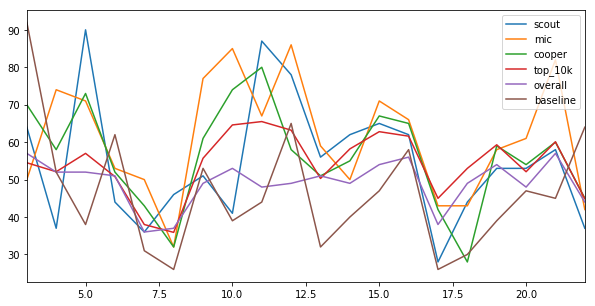

In [178]:
%matplotlib inline
team_points.loc[3:].plot(figsize=(10,5))

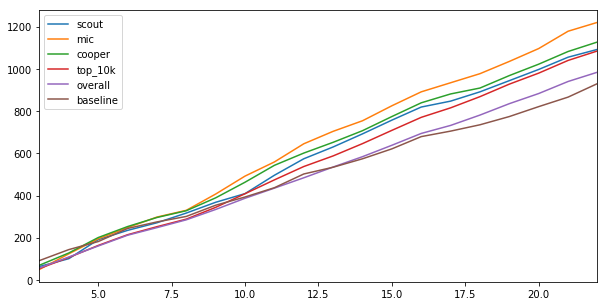

In [179]:
team_points.loc[3:].cumsum().plot(figsize=(10,5))

In [180]:
team_points.loc[3:].sum()

scout       1092.0
mic         1220.0
cooper      1127.0
top_10k     1084.6
overall      984.0
baseline     930.0
dtype: float64

In [181]:
df.head()

,id_,web_name,team,element_type,assists,bonus,bps,clean_sheets,goals_scored,minutes,saves,total_points,transfers_in,transfers_out,total_points_1,total_points_2,total_points_3,total_points_4,total_points_5,total_points_6,total_points_7,total_points_8,total_points_9,total_points_10,total_points_11,total_points_12,total_points_13,total_points_14,total_points_15,total_points_16,total_points_17,total_points_18,total_points_19,total_points_20,total_points_21,total_points_22,total_points_23,value_1,value_2,value_3,value_4,value_5,value_6,value_7,value_8,value_9,value_10,value_11,value_12,value_13,value_14,value_15,value_16,value_17,value_18,value_19,value_20,value_21,value_22,value_23,minutes_1,minutes_2,minutes_3,minutes_4,minutes_5,minutes_6,minutes_7,minutes_8,minutes_9,minutes_10,minutes_11,minutes_12,minutes_13,minutes_14,minutes_15,minutes_16,minutes_17,minutes_18,minutes_19,minutes_20,minutes_21,minutes_22,minutes_23
0,215,De Bruyne,11,3,17,20,652,10,7,1890,0,159,4746708,2422150,7.0,11.0,5.0,13.0,1.0,17.0,9.0,0.0,3.0,6.0,2.0,2.0,7.0,10.0,3.0,1.0,19.0,4.0,5.0,14.0,2.0,9.0,2,95.0,1000.0,96.0,1000.0,98.0,1000.0,99.0,100.0,100.0,101.0,102.0,102.0,102.0,102.0,102.0,103.0,1000.0,103.0,104.0,1000.0,106.0,106.0,107,78.0,90.0,90.0,68.0,33.0,90.0,79.0,0.0,90.0,75.0,90.0,90.0,90.0,90.0,79.0,90.0,90.0,90.0,66.0,90.0,90.0,62.0,90
1,166,Vardy,9,4,6,25,553,7,17,1932,0,150,4046382,1844169,2.0,2.0,8.0,16.0,2.0,2.0,12.0,2.0,8.0,20.0,6.0,12.0,12.0,6.0,5.0,13.0,5.0,9.0,2.0,0.0,0.0,5.0,0,90.0,90.0,89.0,1000.0,89.0,89.0,1000.0,89.0,90.0,1000.0,93.0,1000.0,1000.0,98.0,99.0,100.0,101.0,1000.0,101.0,101.0,101.0,100.0,101,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,0.0,90.0,90
2,192,Mané,10,3,8,18,422,9,11,1777,0,147,3607834,2002411,1.0,13.0,3.0,8.0,15.0,2.0,3.0,12.0,2.0,5.0,12.0,7.0,9.0,2.0,15.0,0.0,6.0,0.0,6.0,11.0,8.0,3.0,3,115.0,1000.0,115.0,115.0,1000.0,116.0,116.0,1000.0,118.0,118.0,1000.0,120.0,121.0,122.0,1000.0,123.0,123.0,0.0,122.0,1000.0,123.0,123.0,124,16.0,90.0,76.0,84.0,90.0,70.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,90.0,0.0,90.0,90.0,77.0,80.0,82
3,191,Salah,10,3,5,15,379,11,11,1703,0,135,2219831,2878509,12.0,3.0,15.0,6.0,9.0,5.0,3.0,2.0,0.0,7.0,2.0,8.0,0.0,3.0,0.0,13.0,16.0,0.0,3.0,3.0,10.0,6.0,7,125.0,125.0,1000.0,125.0,125.0,125.0,125.0,125.0,124.0,124.0,124.0,123.0,123.0,122.0,122.0,1000.0,1000.0,0.0,122.0,123.0,123.0,123.0,123,90.0,78.0,90.0,90.0,90.0,90.0,90.0,90.0,0.0,84.0,64.0,86.0,0.0,68.0,0.0,90.0,90.0,0.0,69.0,90.0,90.0,90.0,90
4,233,Rashford,12,4,5,26,494,4,14,1876,0,134,2962865,3458978,13.0,6.0,0.0,2.0,9.0,2.0,4.0,2.0,9.0,9.0,2.0,5.0,11.0,5.0,13.0,9.0,2.0,2.0,6.0,9.0,2.0,12.0,0,85.0,86.0,87.0,86.0,85.0,85.0,84.0,84.0,1000.0,84.0,85.0,85.0,1000.0,87.0,1000.0,88.0,90.0,91.0,91.0,91.0,91.0,1000.0,91,85.0,88.0,90.0,90.0,90.0,60.0,90.0,90.0,83.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,90.0,62.0,90.0,90.0,58.0,0


In [182]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5.0,0.0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2.0,2.0,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3.0,1.0,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0.0,4.0,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2.0,3.0,438722,38930,37,359,20,20,9.275766,17


In [183]:
def linear_predict(gameweek, data):
    m = ols('next_week_points ~ goals_scored + assists + clean_sheets + saves + value + bps + selected + transfers_in + transfers_out + minutes + points_per_90',  data[data['round'] <= gameweek - 1]).fit()
    next_week = data[data['round'] == gameweek]
    predictions = m.predict(next_week)
    next_week['next_week_predictions'] = predictions   
    return next_week

In [184]:
team_points['linear_points'] = 0

In [185]:
for i in range(2, len(team_points.index)):
    df_linear = linear_predict(i, histories)
    df_copy = df
    df_copy = df_copy.merge(df_linear[['id_', 'next_week_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.next_week_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'next_week_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['next_week_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['next_week_predictions'], ascending=False)
    print(bench_field[['next_week_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)  
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
            dream_team_played_formation.loc[2] <= 5 and
            dream_team_played_formation.loc[3] >= 2 and
            dream_team_played_formation.loc[3] <= 5 and
            dream_team_played_formation.loc[4] >= 1 and
            dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_linear = number_of_alerts_linear + 1
    
    
    print('bench points: ', bench_points)
    
    
    
    
    
    
    captain = dream_team['next_week_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['linear_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_3      web_name  minutes_3
287             2.0        Lloris       90.0
157             1.0          Mina       90.0
322             1.0          Shaw       33.0
323             1.0   El Mohamady        4.0
12              8.0      Sterling       90.0
32              5.0       Martial       90.0
95              3.0  Douglas Luiz       90.0
98              0.0       Shelvey        0.0
8               5.0    Aubameyang       90.0
10             13.0        Agüero       90.0
17              2.0       Firmino       85.0
dream team cost:  827.0
bench budget:  173.0
28        Pope
97       Kelly
395     Hanley
343    Leitner
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_3 web_name  team  minutes_3
343               2.598659             2.0  Leitner    14       80.0
395               2.135174             1.0   Hanley    14       90.0
97                2.027150             2.0    Kelly     7       90.0
1    1
2    3
3    3
4    3
dt

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_4    web_name  minutes_4
29              5.0      Foster       90.0
21              2.0     Pereira       90.0
147             1.0  David Luiz       90.0
351             0.0     Laporte       36.0
12              3.0    Sterling       90.0
25              5.0         Son       78.0
67              8.0       James       90.0
101             5.0        Pépé       90.0
1              16.0       Vardy       90.0
6               5.0     Jiménez       90.0
239             2.0        Gray       81.0
dream team cost:  829.0
bench budget:  171.0
89      Ederson
108      Walker
390    Tanganga
74        Noble
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_4  web_name  team  minutes_4
74                3.054239             3.0     Noble    19       84.0
108               2.681577             6.0    Walker    11       90.0
390               0.000000             0.0  Tanganga    17        0.0
1    1
2    3
3    4
4    3
dtype: int64
num o

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_5     web_name  minutes_5
52              2.0         Leno       90.0
129             6.0      Maguire       90.0
158             1.0        Schär       79.0
159             6.0  Wan-Bissaka       90.0
2              15.0         Mané       90.0
67              2.0        James       90.0
173             2.0      Eriksen       90.0
237             2.0        Iwobi       90.0
6               2.0      Jiménez       69.0
8              13.0   Aubameyang       90.0
22              5.0         Kane       84.0
dream team cost:  828.0
bench budget:  172.0
268          Gunn
136           Aké
415     Schelotto
139    Sigurdsson
Name: web_name, dtype: object
bench cost:  172.0
     next_week_predictions  total_points_5    web_name  team  minutes_5
139               4.369959             2.0  Sigurdsson     8       70.0
136               2.587845             2.0         Aké     3       90.0
415               0.000000             0.0   Schelotto     4        0.0
1    1
2    3
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_6          web_name  minutes_6
52              2.0              Leno       90.0
5               7.0  Alexander-Arnold       90.0
96              6.0           Willems       81.0
159             1.0       Wan-Bissaka       90.0
3               5.0             Salah       90.0
12              0.0          Sterling        0.0
37              2.0          Cantwell       89.0
39              2.0             Mount       90.0
118             3.0           Rodrigo       90.0
10              9.0            Agüero       90.0
11              2.0             Pukki       90.0
dream team cost:  827.0
bench budget:  173.0
24     Henderson
119         Rico
390     Tanganga
4       Rashford
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_6  web_name  team  minutes_6
4                 5.464364             2.0  Rashford    12       60.0
119               2.063007             5.0      Rico     3       90.0
390               0.000000             0

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_7          web_name  minutes_7
52              3.0              Leno       90.0
5               6.0  Alexander-Arnold       90.0
13              8.0          van Dijk       90.0
136             5.0               Aké       90.0
25              5.0               Son       63.0
37              2.0          Cantwell       80.0
39              6.0             Mount       90.0
101             2.0              Pépé       73.0
8               9.0        Aubameyang       90.0
11              2.0             Pukki       90.0
22              8.0              Kane       90.0
dream team cost:  830.0
bench budget:  170.0
78       de Gea
55        Digne
390    Tanganga
183       Kanté
Name: web_name, dtype: object
bench cost:  168.0
     next_week_predictions  total_points_7  web_name  team  minutes_7
55                3.478924             1.0     Digne     8       90.0
183               3.023091             0.0     Kanté     6        0.0
390               0.000000             0.0  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_8    web_name  minutes_8
43              7.0        Ryan       90.0
20              5.0   Lundstram       90.0
55              2.0       Digne       90.0
131             2.0   Cresswell       83.0
0               0.0   De Bruyne        0.0
12              2.0    Sterling       90.0
107             1.0      McGinn       90.0
168             1.0  Yarmolenko       77.0
8               2.0  Aubameyang       90.0
11              1.0       Pukki       83.0
22              2.0        Kane       90.0
dream team cost:  828.0
bench budget:  172.0
89       Ederson
108       Walker
390     Tanganga
134    McTominay
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_8   web_name  team  minutes_8
108               3.411543             1.0     Walker    11       45.0
134               3.081203             1.0  McTominay    12       90.0
390               0.000000             0.0   Tanganga    17        0.0
1    1
2    3
3    3
4    3
dtype: int

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_9          web_name  minutes_9
35              3.0        Schmeichel       90.0
5               2.0  Alexander-Arnold       90.0
13              2.0          van Dijk       90.0
140             1.0       van Aanholt       90.0
3               0.0             Salah        0.0
12              5.0          Sterling       90.0
39              3.0             Mount       63.0
183             0.0             Kanté        0.0
7               2.0           Abraham       90.0
11              1.0             Pukki       90.0
53              2.0            Haller       90.0
dream team cost:  828.0
bench budget:  172.0
369    McGovern
97        Kelly
119        Rico
37     Cantwell
Name: web_name, dtype: object
bench cost:  172.0
     next_week_predictions  total_points_9  web_name  team  minutes_9
37                2.863011             3.0  Cantwell    14       80.0
97                2.611525             0.0     Kelly     7        0.0
119               2.482748             8.0  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_10          web_name  minutes_10
330              2.0           Roberto        90.0
5                1.0  Alexander-Arnold        90.0
13               2.0          van Dijk        90.0
151             -1.0           Webster        90.0
0                6.0         De Bruyne        75.0
2                5.0              Mané        90.0
33               2.0              Alli        90.0
60              11.0         Tielemans        90.0
1               20.0             Vardy        90.0
7                5.0           Abraham        69.0
11               2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
398      Hennessey
14       Robertson
159    Wan-Bissaka
440       Pussetto
Name: web_name, dtype: object
bench cost:  167.0
     next_week_predictions  total_points_10     web_name  team  minutes_10
14                3.562414              2.0    Robertson    10        90.0
159               3.144160              1.0  Wan-Bissaka    12      

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_11     web_name  minutes_11
124              2.0    Gazzaniga        90.0
20              21.0    Lundstram        90.0
147              2.0   David Luiz        90.0
156              2.0     Sokratis        90.0
2               12.0         Mané        90.0
3                2.0        Salah        64.0
41               1.0  David Silva        45.0
134              2.0    McTominay        90.0
4                2.0     Rashford        90.0
11               2.0        Pukki        90.0
22               0.0         Kane         0.0
dream team cost:  829.0
bench budget:  171.0
268                Gunn
5      Alexander-Arnold
390            Tanganga
68            Henderson
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_11          web_name  team  \
5                 3.748233              7.0  Alexander-Arnold    10   
68                3.163849              2.0         Henderson    10   
390               0.000000              0.0  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_12          web_name  minutes_12
29              9.0            Foster        90.0
5               2.0  Alexander-Arnold        90.0
13              2.0          van Dijk        90.0
14              5.0         Robertson        90.0
55              2.0             Digne        90.0
0               2.0         De Bruyne        90.0
39              3.0             Mount        86.0
82              8.0           Pulisic        79.0
1              12.0             Vardy        90.0
8               2.0        Aubameyang        90.0
11              2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
78          de Gea
448        Lamptey
58     Ward-Prowse
107         McGinn
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_12     web_name  team  minutes_12
58                3.291757              2.0  Ward-Prowse    16        90.0
107               3.264535              2.0       McGinn     2        90.0
448  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_13   web_name  minutes_13
330              2.0    Roberto        90.0
13               2.0   van Dijk        90.0
20               3.0  Lundstram        90.0
62               0.0       Dunk         0.0
2                9.0       Mané        90.0
3                0.0      Salah         0.0
16               3.0   Maddison        90.0
82               2.0    Pulisic        90.0
4               11.0   Rashford        90.0
6                7.0    Jiménez        90.0
7                2.0    Abraham        72.0
dream team cost:  829.0
bench budget:  171.0
43          Ryan
14     Robertson
448      Lamptey
245      Fabinho
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_13   web_name  team  minutes_13
14                3.786909              6.0  Robertson    10        90.0
245               3.252234              1.0    Fabinho    10        90.0
448               0.000000              0.0    Lamptey     6         0.0
1    1
2    2
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_14          web_name  minutes_14
43               2.0              Ryan        90.0
5               10.0  Alexander-Arnold        90.0
14               2.0         Robertson        90.0
20               2.0         Lundstram        90.0
47               2.0           Söyüncü        90.0
0               10.0         De Bruyne        90.0
2                2.0              Mané        90.0
16               2.0          Maddison        90.0
6                5.0           Jiménez        90.0
22               2.0              Kane        90.0
106              2.0            Barnes        61.0
dream team cost:  830.0
bench budget:  170.0
91      Alisson
13     van Dijk
37     Cantwell
440    Pussetto
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_14  web_name  team  minutes_14
13                3.628456             17.0  van Dijk    10        90.0
37                2.841295              8.0  Cantwell    14        82.0
440           

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_15     web_name  minutes_15
43              3.0         Ryan        90.0
20              1.0    Lundstram        90.0
47              5.0      Söyüncü        90.0
62              2.0         Dunk        90.0
0               3.0    De Bruyne        79.0
2              15.0         Mané        90.0
12              3.0     Sterling        71.0
58              5.0  Ward-Prowse        90.0
1               5.0        Vardy        90.0
6               2.0      Jiménez        83.0
9               9.0         Ings        76.0
dream team cost:  830.0
bench budget:  170.0
191    McCarthy
97        Kelly
403      Kilman
37     Cantwell
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_15  web_name  team  minutes_15
37                3.049299              2.0  Cantwell    14        82.0
97                2.643130              6.0     Kelly     7        90.0
403               2.209492              0.0    Kilman    20         0.0
1    1
2    3


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_16          web_name  minutes_16
43              2.0              Ryan        90.0
5               1.0  Alexander-Arnold        50.0
13              6.0          van Dijk        90.0
20              2.0         Lundstram        90.0
0               1.0         De Bruyne        90.0
25             12.0               Son        90.0
33              9.0              Alli        84.0
39              2.0             Mount        90.0
1              13.0             Vardy        90.0
7               2.0           Abraham        90.0
11              2.0             Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
318      Martin
97        Kelly
151     Webster
37     Cantwell
Name: web_name, dtype: object
bench cost:  171.0
     next_week_predictions  total_points_16  web_name  team  minutes_16
151               2.754041              1.0   Webster     4        90.0
37                2.725414              1.0  Cantwell    14        18.0
97                2.647764

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_17    web_name  minutes_17
78              3.0      de Gea        90.0
13              7.0    van Dijk        90.0
20             11.0   Lundstram        90.0
97              2.0       Kelly        90.0
0              19.0   De Bruyne        90.0
16              2.0    Maddison        90.0
19              0.0    Grealish        90.0
33              2.0        Alli        90.0
1               5.0       Vardy        90.0
7               2.0     Abraham        90.0
8               2.0  Aubameyang        90.0
dream team cost:  826.0
bench budget:  174.0
191    McCarthy
119        Rico
266       Konsa
193      Tettey
Name: web_name, dtype: object
bench cost:  174.0
     next_week_predictions  total_points_17 web_name  team  minutes_17
193               2.775604              1.0   Tettey    14        90.0
119               2.518424              6.0     Rico     3        90.0
266               2.274132              0.0    Konsa     2         0.0
1    1
2    3
3    4
4    3
dt

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_18  web_name  minutes_18
44              2.0    Guaita        90.0
13              0.0  van Dijk         0.0
47              0.0   Söyüncü        90.0
97              2.0     Kelly        90.0
2               0.0      Mané         0.0
16              2.0  Maddison        90.0
25             -1.0       Son        61.0
37             10.0  Cantwell        86.0
1               9.0     Vardy        90.0
4               2.0  Rashford        90.0
7               2.0   Abraham        79.0
dream team cost:  828.0
bench budget:  172.0
70             Pickford
5      Alexander-Arnold
119                Rico
384                Duda
Name: web_name, dtype: object
bench cost:  170.0
     next_week_predictions  total_points_18          web_name  team  \
5                 4.114337              0.0  Alexander-Arnold    10   
119               2.685838              1.0              Rico     3   
384               0.000000              0.0              Duda    14   

     minutes_18  
5  

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


     total_points_19    web_name  minutes_19
35               0.0  Schmeichel        90.0
20               2.0   Lundstram        90.0
97               2.0       Kelly        90.0
119              0.0        Rico         0.0
0                5.0   De Bruyne        66.0
12              10.0    Sterling        90.0
16               1.0    Maddison        75.0
19               6.0    Grealish        90.0
4                6.0    Rashford        62.0
6               11.0     Jiménez        90.0
22               8.0        Kane        90.0
dream team cost:  830.0
bench budget:  170.0
29              Foster
5     Alexander-Arnold
55               Digne
39               Mount
Name: web_name, dtype: object
bench cost:  170.0
    next_week_predictions  total_points_19          web_name  team  minutes_19
39               3.819950              1.0             Mount     6        45.0
55               3.229065              6.0             Digne     8        90.0
5                0.000000            

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_20   web_name  minutes_20
28              1.0       Pope        90.0
13              6.0   van Dijk        90.0
14              6.0  Robertson        90.0
20              0.0  Lundstram         0.0
0              14.0  De Bruyne        90.0
19              1.0   Grealish        90.0
33              2.0       Alli        90.0
37              1.0   Cantwell         4.0
1               0.0      Vardy         0.0
7               7.0    Abraham        90.0
22              8.0       Kane        90.0
dream team cost:  827.0
bench budget:  173.0
124     Gazzaniga
97          Kelly
423       Simpson
105    Dendoncker
Name: web_name, dtype: object
bench cost:  173.0
     next_week_predictions  total_points_20    web_name  team  minutes_20
97                3.178873              2.0       Kelly     7        90.0
105               2.570994              1.0  Dendoncker    20        57.0
423               2.333061              0.0     Simpson     3         0.0
1    1
2    2
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_21    web_name  minutes_21
35              6.0  Schmeichel        90.0
13              7.0    van Dijk        90.0
62              4.0        Dunk        90.0
97              2.0       Kelly        82.0
3              10.0       Salah        90.0
12              1.0    Sterling         1.0
19             13.0    Grealish        90.0
32              2.0     Martial        90.0
4               2.0    Rashford        90.0
7               5.0     Abraham        90.0
9               9.0        Ings        75.0
dream team cost:  827.0
bench budget:  173.0
90          Krul
119         Rico
278     Williams
210    Guendouzi
Name: web_name, dtype: object
bench cost:  173.0
     next_week_predictions  total_points_21   web_name  team  minutes_21
119               2.634743             -1.0       Rico     3        45.0
210               2.392210              1.0  Guendouzi     1         8.0
278               2.251616              0.0   Williams    12         0.0
1    1
2    3
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_22          web_name  minutes_22
35              4.0        Schmeichel        90.0
5               6.0  Alexander-Arnold        90.0
13              6.0          van Dijk        90.0
20              6.0         Lundstram        69.0
47              1.0           Söyüncü        90.0
0               9.0         De Bruyne        62.0
2               3.0              Mané        80.0
27              2.0            Traoré        90.0
32              8.0           Martial        79.0
4              12.0          Rashford        58.0
7               6.0           Abraham        90.0
dream team cost:  828.0
bench budget:  172.0
70     Pickford
97        Kelly
432        Rupp
6       Jiménez
Name: web_name, dtype: object
bench cost:  172.0
     next_week_predictions  total_points_22 web_name  team  minutes_22
6                 4.016204              2.0  Jiménez    20        90.0
97                3.001043              2.0    Kelly     7        90.0
432               0.000000   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


    total_points_23          web_name  minutes_23
35                2        Schmeichel          90
5                10  Alexander-Arnold          90
13               15          van Dijk          90
20                2         Lundstram          66
2                 3              Mané          82
16                2          Maddison          90
18                0       Richarlison           0
27               10            Traoré          90
1                 0             Vardy          90
7                 2           Abraham          79
9                 2              Ings          90
dream team cost:  826.0
bench budget:  174.0
124     Gazzaniga
97          Kelly
390      Tanganga
105    Dendoncker
Name: web_name, dtype: object
bench cost:  174.0
     next_week_predictions  total_points_23    web_name  team  minutes_23
97                3.130967                1       Kelly     7          90
105               2.858575                2  Dendoncker    20          90
390         

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


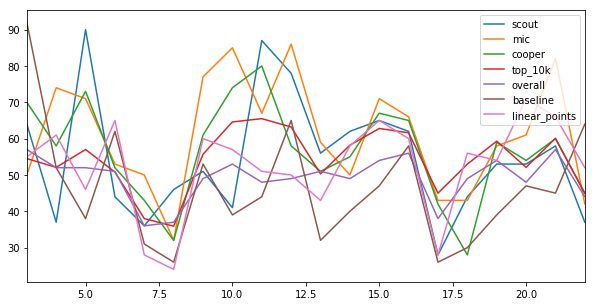

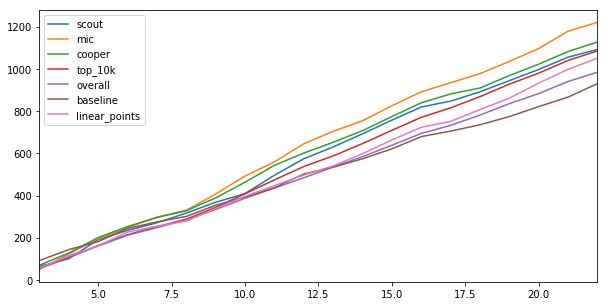

In [186]:
%matplotlib inline
team_points.loc[3:].sum()
team_points.loc[3:].plot(figsize=(10,5))
team_points.loc[3:].cumsum().plot(figsize=(10,5))

In [187]:
from sklearn.ensemble import RandomForestRegressor

In [188]:
team_points.shape

(23, 7)

In [189]:
histories.head()

,id_,web_name,value,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,team_a_score,team_h_score,transfers_in,transfers_out,sum_points,sum_minutes,team_a_conceded_rank,team_a_conceded_rank_next,points_per_90,next_week_points
0,215,De Bruyne,95,1,1,37,1,0,78,1,0,868463,7,5.0,0.0,0,0,7,78,20,13,8.076923,11
1,215,De Bruyne,95,2,3,44,0,0,90,2,0,995410,11,2.0,2.0,81457,79408,18,168,13,14,9.642857,5
2,215,De Bruyne,96,1,0,22,0,0,90,3,0,1566970,5,3.0,1.0,510105,49567,23,258,14,15,8.023256,13
3,215,De Bruyne,97,1,2,41,1,1,68,4,0,1914603,13,0.0,4.0,373295,80225,36,326,15,20,9.938650,1
4,215,De Bruyne,98,0,0,6,0,0,33,5,0,2386410,1,2.0,3.0,438722,38930,37,359,20,20,9.275766,17


In [190]:
df_forest = histories[['id_', 'assists', 'bonus', 'bps', 'clean_sheets', 'goals_scored', 
                 'minutes', 'round', 'saves', 'selected', 
                 'total_points',
                 'transfers_in', 
                 'team_a_conceded_rank', 'team_a_conceded_rank_next',
                 'transfers_out',
                 'points_per_90', 'next_week_points']].sort_values('round')

In [191]:
df_forest.head()

,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points
0,215,1,1,37,1,0,78,1,0,868463,7,0,20,13,0,8.076923,11
3528,106,0,0,0,0,0,0,1,0,514779,0,0,10,9,0,0.000000,1
3552,271,0,0,20,0,0,90,1,0,432483,2,0,1,15,0,2.000000,2
3576,184,0,0,10,0,0,90,1,0,101038,2,0,16,17,0,2.000000,0
3600,307,0,0,13,0,0,90,1,0,43489,1,0,1,9,0,1.000000,1


In [192]:
def forest_predict(gameweek):
    df_clean = df_forest.drop('id_', axis=1)
    df_clean = df_clean[df_clean['round'] <= gameweek - 1]
    X_train = df_clean.drop('next_week_points', axis=1)
    y_train = df_clean.next_week_points
    rfr = RandomForestRegressor(n_estimators=200, max_depth=5)
    rfr.fit(X_train, y_train)
    next_week = df_forest[df_forest['round'] == gameweek]
    X_test = next_week.drop(['id_', 'next_week_points'], axis=1)
    y_pred = rfr.predict(X_test)
    next_week['forest_predictions'] = y_pred
    return next_week
    
    
    

In [203]:
forest_predict(23).head()

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,id_,assists,bonus,bps,clean_sheets,goals_scored,minutes,round,saves,selected,total_points,transfers_in,team_a_conceded_rank,team_a_conceded_rank_next,transfers_out,points_per_90,next_week_points,forest_predictions
10223,231,0,0,0,0,0,0,23,0,10900,0,108,1,15,253,2.000000,1,0.543088
429,187,0,0,17,1,0,82,23,0,810469,2,176015,5,8,28170,5.122768,7,3.696189
6019,453,0,0,5,0,0,23,23,0,19082,1,170,12,4,619,4.383562,1,1.377376
2710,414,0,0,11,0,0,90,23,0,341911,1,4790,18,1,10978,2.895034,2,1.985420
8514,434,0,0,2,0,0,5,23,0,4159,1,23,16,8,90,9.750000,1,1.096462


In [194]:
team_points['forest_points'] = 0

In [195]:
for i in range(2, len(team_points.index)):
    df_forest_predictions = forest_predict(i)
    df_copy = df
    df_copy = df_copy.merge(df_forest_predictions[['id_', 'forest_predictions']], how='left', on='id_')
    df_copy = df_copy.fillna(0)
    dream_team = team_select(df_copy.forest_predictions, df_copy['value_' + str(i)], df_copy)
    next_week_points = dream_team['total_points_' + str(i+1)]
    print(dream_team[['total_points_' + str(i+1), 'web_name', 'minutes_' + str(i + 1)]])
    
    dream_team_cost = dream_team['value_' + str(i)].sum()
    print('dream team cost: ', dream_team_cost)
    bench_budget = 1000 - dream_team_cost
    print('bench budget: ', bench_budget)
    bench_pool = df_copy
    bench_pool.loc[(bench_pool['id_'].isin(dream_team['id_'])), 'forest_predictions'] = 0


    dream_team_formation = dream_team['element_type'].value_counts().sort_index()
    bench_formation = [1, 5 - dream_team_formation[2], 5 - dream_team_formation[3], 3 - dream_team_formation[4]]
    bench = bench_select(bench_pool['forest_predictions'],
                         bench_pool['value_' + str(i)],
                         bench_formation,
                         bench_budget,
                         bench_pool)
    
    print(bench.web_name)
    print('bench cost: ', bench['value_' + str(i)].sum())
    
    
    bench_keeper = bench[bench['element_type'] == 1]
    bench_field = bench[bench['element_type'] != 1].sort_values(['forest_predictions'], ascending=False)
    print(bench_field[['forest_predictions', 'total_points_' + str(i + 1), 'web_name', 'team', 'minutes_' + str(i + 1)]])

    
    benched = dream_team[dream_team['minutes_' + str(i + 1)] == 0]
    
    dream_team_played = dream_team[dream_team['minutes_' + str(i + 1)] > 0]
    dream_team_played_formation = dream_team_played['element_type'].value_counts().sort_index()
    dream_team_played_formation_template = pd.Series([0, 0, 0, 0], index=[1, 2, 3, 4])
    for position in dream_team_played_formation.index:
        dream_team_played_formation_template.loc[position] = dream_team_played_formation.loc[position]
    dream_team_played_formation = dream_team_played_formation_template
    print(dream_team_played_formation)
    
    number_of_benched = benched.shape[0]
    print('num of benched: ', number_of_benched)

    bench_points = 0
    
        
    if benched[benched['element_type'] == 1].shape[0] > 0:
        bench_points = bench_points + int(bench_keeper['total_points_' + str(i + 1)])
        number_of_benched = number_of_benched - 1
    
    
    
    if (dream_team_played_formation.loc[2] >= 3 and
                    dream_team_played_formation.loc[2] <= 5 and
                    dream_team_played_formation.loc[3] >= 2 and
                    dream_team_played_formation.loc[3] <= 5 and
                    dream_team_played_formation.loc[4] >= 1 and
                    dream_team_played_formation.loc[4] <= 5):
        bench_points = bench_points + sum(bench_field['total_points_' + str(i + 1)].iloc[:number_of_benched])
        
    else:
        print('ALERT! bench points not added')
        number_of_alerts_forest = number_of_alerts_forest + 1

    
    print('bench points: ', bench_points)

    
    
    
    
    captain = dream_team['forest_predictions'].idxmax()
    final_points = sum(next_week_points) + dream_team['total_points_' + str(i+1)][captain] + bench_points
    team_points['forest_points'].loc[i] = final_points

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_3     web_name  minutes_3
78              1.0       de Gea       90.0
62              1.0         Dunk       90.0
97              2.0        Kelly       90.0
323             1.0  El Mohamady        4.0
92              2.0     Trossard       90.0
99              2.0  Lucas Moura       90.0
112             2.0        Neves       90.0
117             1.0         Groß       12.0
4               0.0     Rashford       90.0
8               5.0   Aubameyang       90.0
375             0.0   Chicharito        0.0
dream team cost:  697.0
bench budget:  303.0
51        Patrício
38           Evans
159    Wan-Bissaka
32         Martial
Name: web_name, dtype: object
bench cost:  231.0
     forest_predictions  total_points_3     web_name  team  minutes_3
32             3.959848             5.0      Martial    12       90.0
159            3.457058             0.0  Wan-Bissaka    12       90.0
38             3.174964             2.0        Evans     9       90.0
1    1
2    3
3    4
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_4       web_name  minutes_4
114             3.0         Heaton       90.0
13              7.0       van Dijk       90.0
14              6.0      Robertson       90.0
136             1.0            Aké       90.0
12              3.0       Sterling       90.0
56              3.0           Zaha       90.0
139             5.0     Sigurdsson       90.0
252             1.0       Townsend        6.0
1              16.0          Vardy       90.0
11              2.0          Pukki       90.0
61              5.0  Callum Wilson       90.0
dream team cost:  796.0
bench budget:  204.0
289         Adrián
64        Chilwell
159    Wan-Bissaka
37        Cantwell
Name: web_name, dtype: object
bench cost:  202.0
     forest_predictions  total_points_4     web_name  team  minutes_4
37             4.026627             2.0     Cantwell    14       77.0
159            3.389264             2.0  Wan-Bissaka    12       90.0
64             3.330205             5.0     Chilwell     9       90.

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_5        web_name  minutes_5
89              1.0         Ederson       90.0
13              2.0        van Dijk       90.0
14              5.0       Robertson       90.0
97              0.0           Kelly        0.0
108             1.0          Walker       90.0
159             6.0     Wan-Bissaka       90.0
71              4.0  Bernardo Silva       72.0
139             2.0      Sigurdsson       70.0
8              13.0      Aubameyang       90.0
17              8.0         Firmino       53.0
22              5.0            Kane       84.0
dream team cost:  825.0
bench budget:  175.0
78         de Gea
105    Dendoncker
122        Fraser
384          Duda
Name: web_name, dtype: object
bench cost:  174.0
     forest_predictions  total_points_5    web_name  team  minutes_5
122            4.284589             7.0      Fraser     3       33.0
105            3.502579             1.0  Dendoncker    20       45.0
384            0.000000             0.0        Duda    14      

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_6        web_name  minutes_6
78              2.0          de Gea       90.0
13              2.0        van Dijk       90.0
14              8.0       Robertson       90.0
159             1.0     Wan-Bissaka       90.0
12              0.0        Sterling        0.0
37              2.0        Cantwell       89.0
39              2.0           Mount       90.0
71             19.0  Bernardo Silva       90.0
4               2.0        Rashford       60.0
11              2.0           Pukki       90.0
120             2.0            King       90.0
dream team cost:  776.0
bench budget:  224.0
287        Lloris
20      Lundstram
129       Maguire
105    Dendoncker
Name: web_name, dtype: object
bench cost:  197.0
     forest_predictions  total_points_6    web_name  team  minutes_6
129            4.385797             1.0     Maguire    12       90.0
105            4.110705             0.0  Dendoncker    20       64.0
20             2.889151            12.0   Lundstram    15      

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_7  web_name  minutes_7
89              4.0   Ederson       90.0
13              8.0  van Dijk       90.0
108             2.0    Walker       90.0
392             0.0     Sakho        0.0
2               3.0      Mané       90.0
3               3.0     Salah       90.0
37              2.0  Cantwell       80.0
39              6.0     Mount       90.0
6               2.0   Jiménez       79.0
7               2.0   Abraham       83.0
11              2.0     Pukki       90.0
dream team cost:  808.0
bench budget:  192.0
43           Ryan
136           Aké
137         Coady
105    Dendoncker
Name: web_name, dtype: object
bench cost:  190.0
     forest_predictions  total_points_7    web_name  team  minutes_7
105            3.721157             3.0  Dendoncker    20       90.0
137            3.456998             7.0       Coady    20       90.0
136            3.408519             5.0         Aké     3       90.0
1    1
2    2
3    4
4    3
dtype: int64
num of benched:  1
ALERT!

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_8    web_name  minutes_8
24              6.0   Henderson       90.0
20              5.0   Lundstram       90.0
26              6.0     Baldock       90.0
244             6.0      Engels       74.0
0               0.0   De Bruyne        0.0
12              2.0    Sterling       90.0
107             1.0      McGinn       90.0
269             2.0     Nakamba       90.0
6              10.0     Jiménez       90.0
7               8.0     Abraham       83.0
8               2.0  Aubameyang       90.0
dream team cost:  757.0
bench budget:  243.0
114             Heaton
36             Stevens
176           Guilbert
250    Callum Robinson
Name: web_name, dtype: object
bench cost:  192.0
     forest_predictions  total_points_8         web_name  team  minutes_8
250            4.655254             3.0  Callum Robinson    15       70.0
176            4.498247             1.0         Guilbert     2       90.0
36             4.496884             6.0          Stevens    15       90.0
1 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_9    web_name  minutes_9
48              6.0    Ramsdale       90.0
55              6.0       Digne       90.0
172             2.0  Vertonghen       90.0
305             0.0      Stacey        0.0
37              3.0    Cantwell       80.0
169             1.0     Sissoko       90.0
173             0.0     Eriksen        0.0
277             1.0    Ceballos       45.0
7               2.0     Abraham       90.0
11              1.0       Pukki       90.0
219             2.0     Solanke       61.0
dream team cost:  648.0
bench budget:  352.0
124       Gazzaniga
119            Rico
189      Steve Cook
69     Harry Wilson
Name: web_name, dtype: object
bench cost:  196.0
     forest_predictions  total_points_9      web_name  team  minutes_9
69             5.062746             3.0  Harry Wilson     3       68.0
189            4.803851             9.0    Steve Cook     3       90.0
119            4.762790             8.0          Rico     3       90.0
1    1
2    2
3    3
4    

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_10        web_name  minutes_10
78               2.0          de Gea        90.0
38               6.0           Evans        90.0
55              -1.0           Digne        90.0
64              19.0        Chilwell        90.0
0                6.0       De Bruyne        75.0
37               1.0        Cantwell        45.0
67               6.0           James        79.0
71               3.0  Bernardo Silva        90.0
141              3.0         Pereira        81.0
11               2.0           Pukki        90.0
22               7.0            Kane        90.0
dream team cost:  738.0
bench budget:  262.0
35    Schmeichel
21       Pereira
47       Söyüncü
1          Vardy
Name: web_name, dtype: object
bench cost:  250.0
    forest_predictions  total_points_10 web_name  team  minutes_10
1             4.090502             20.0    Vardy     9        90.0
47            4.005971              6.0  Söyüncü     9        90.0
21            3.975156              6.0  Pereira 

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_11     web_name  minutes_11
43               6.0         Ryan        90.0
13               1.0     van Dijk        90.0
62               7.0         Dunk        90.0
227              0.0        Mendy         0.0
0                2.0    De Bruyne        90.0
3                2.0        Salah        64.0
39               1.0        Mount        90.0
41               1.0  David Silva        45.0
7               12.0      Abraham        87.0
11               2.0        Pukki        90.0
211              2.0     Connolly        85.0
dream team cost:  780.0
bench budget:  220.0
89      Ederson
294     Cancelo
307      Stones
181    Gündogan
Name: web_name, dtype: object
bench cost:  219.0
     forest_predictions  total_points_11  web_name  team  minutes_11
181            5.654846              1.0  Gündogan    11        90.0
294            5.293532              0.0   Cancelo    11         0.0
307            5.136920              2.0    Stones    11        90.0
1    1
2    2


C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_12        web_name  minutes_12
29               9.0          Foster        90.0
55               2.0           Digne        90.0
64               6.0        Chilwell        90.0
157              2.0            Mina        90.0
0                2.0       De Bruyne        90.0
18              10.0     Richarlison        88.0
39               3.0           Mount        86.0
71              10.0  Bernardo Silva        90.0
1               12.0           Vardy        90.0
10               2.0          Agüero        70.0
11               2.0           Pukki        90.0
dream team cost:  829.0
bench budget:  171.0
369      McGovern
170       Holgate
228       Janmaat
105    Dendoncker
Name: web_name, dtype: object
bench cost:  171.0
     forest_predictions  total_points_12    web_name  team  minutes_12
105            3.738517              2.0  Dendoncker    20        90.0
228            3.728926              7.0     Janmaat    18        90.0
170            3.531097          

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_13    web_name  minutes_13
52               9.0        Leno        90.0
55               1.0       Digne        90.0
147              1.0  David Luiz        90.0
157              1.0        Mina        90.0
2                9.0        Mané        90.0
39               1.0       Mount        16.0
82               2.0     Pulisic        90.0
139              2.0  Sigurdsson        90.0
11               5.0       Pukki        90.0
22               6.0        Kane        90.0
109             12.0   Lacazette        90.0
dream team cost:  827.0
bench budget:  173.0
191        McCarthy
200        Chambers
249          Taylor
349    Schneiderlin
Name: web_name, dtype: object
bench cost:  173.0
     forest_predictions  total_points_13      web_name  team  minutes_13
200            4.182922              1.0      Chambers     1        45.0
349            3.525543              0.0  Schneiderlin     8        55.0
249            2.727296              6.0        Taylor     5       

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_14   web_name  minutes_14
29              2.0     Foster        90.0
21              7.0    Pereira        90.0
47              2.0    Söyüncü        90.0
64              2.0   Chilwell        90.0
0              10.0  De Bruyne        90.0
2               2.0       Mané        90.0
37              8.0   Cantwell        82.0
82              2.0    Pulisic        90.0
7               0.0    Abraham         0.0
10              0.0     Agüero         0.0
63              2.0   Deulofeu        66.0
dream team cost:  822.0
bench budget:  178.0
52           Leno
200      Chambers
278      Williams
105    Dendoncker
Name: web_name, dtype: object
bench cost:  178.0
     forest_predictions  total_points_14    web_name  team  minutes_14
200            3.280750              0.0    Chambers     1        90.0
105            3.000082              1.0  Dendoncker    20        90.0
278            2.969015              0.0    Williams    12        78.0
1    1
2    3
3    4
4    1
dtype:

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_15     web_name  minutes_15
35              6.0   Schmeichel        90.0
14              1.0    Robertson        90.0
20              1.0    Lundstram        90.0
21              7.0      Pereira        90.0
0               3.0    De Bruyne        79.0
12              3.0     Sterling        71.0
37              2.0     Cantwell        82.0
41              9.0  David Silva        90.0
1               5.0        Vardy        90.0
6               2.0      Jiménez        83.0
11              8.0        Pukki        90.0
dream team cost:  820.0
bench budget:  180.0
43          Ryan
62          Dunk
97         Kelly
210    Guendouzi
Name: web_name, dtype: object
bench cost:  180.0
     forest_predictions  total_points_15   web_name  team  minutes_15
97             3.931774              6.0      Kelly     7        90.0
62             3.829169              2.0       Dunk     4        90.0
210            3.550407              0.0  Guendouzi     1         0.0
1    1
2    3
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_16    web_name  minutes_16
35               2.0  Schmeichel        90.0
20               2.0   Lundstram        90.0
21               1.0     Pereira        90.0
97               8.0       Kelly        90.0
25              12.0         Son        90.0
33               9.0        Alli        84.0
39               2.0       Mount        90.0
148              2.0      Hayden        90.0
1               13.0       Vardy        90.0
7                2.0     Abraham        90.0
86               2.0     Mousset        64.0
dream team cost:  730.0
bench budget:  270.0
51            Patrício
5     Alexander-Arnold
47             Söyüncü
98             Shelvey
Name: web_name, dtype: object
bench cost:  224.0
    forest_predictions  total_points_16          web_name  team  minutes_16
98            4.030759              9.0           Shelvey    13        90.0
5             4.006051              1.0  Alexander-Arnold    10        50.0
47            3.955756              2.0       

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_17   web_name  minutes_17
24              6.0  Henderson        90.0
13              7.0   van Dijk        90.0
20             11.0  Lundstram        90.0
47              3.0    Söyüncü        90.0
97              2.0      Kelly        90.0
2               6.0       Mané        90.0
16              2.0   Maddison        90.0
39              2.0      Mount        90.0
1               5.0      Vardy        90.0
4               2.0   Rashford        90.0
7               2.0    Abraham        90.0
dream team cost:  788.0
bench budget:  212.0
318       Martin
38         Evans
60     Tielemans
98       Shelvey
Name: web_name, dtype: object
bench cost:  208.0
    forest_predictions  total_points_17   web_name  team  minutes_17
38            4.357173              2.0      Evans     9        90.0
60            4.008935              2.0  Tielemans     9        90.0
98            3.511014              0.0    Shelvey    13         0.0
1    1
2    4
3    3
4    3
dtype: int64
num o

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_18     web_name  minutes_18
51               4.0     Patrício        90.0
97               2.0        Kelly        90.0
126              1.0      Targett        90.0
159              1.0  Wan-Bissaka        90.0
2                0.0         Mané         0.0
25              -1.0          Son        61.0
32               2.0      Martial        90.0
39               3.0        Mount        90.0
4                2.0     Rashford        90.0
6                7.0      Jiménez        90.0
7                2.0      Abraham        79.0
dream team cost:  802.0
bench budget:  198.0
114     Heaton
47     Söyüncü
119       Rico
107     McGinn
Name: web_name, dtype: object
bench cost:  197.0
     forest_predictions  total_points_18 web_name  team  minutes_18
107            3.969873              1.0   McGinn     2         7.0
119            3.570662              1.0     Rico     3        90.0
47             3.486724              0.0  Söyüncü     9        90.0
1    1
2    3
3    3
4

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


     total_points_19    web_name  minutes_19
114             10.0      Heaton        90.0
20               2.0   Lundstram        90.0
26               6.0     Baldock        90.0
97               2.0       Kelly        90.0
0                5.0   De Bruyne        66.0
16               1.0    Maddison        75.0
19               6.0    Grealish        90.0
39               1.0       Mount        45.0
7                2.0     Abraham        90.0
8                7.0  Aubameyang        90.0
11               1.0       Pukki        90.0
dream team cost:  751.0
bench budget:  249.0
43        Ryan
47     Söyüncü
177     Tomori
25         Son
Name: web_name, dtype: object
bench cost:  248.0
     forest_predictions  total_points_19 web_name  team  minutes_19
25             4.042061              0.0      Son    17         0.0
47             3.734662              0.0  Söyüncü     9        90.0
177            3.681019              0.0   Tomori     6        90.0
1    1
2    3
3    4
4    3
dtype:

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_20   web_name  minutes_20
44              3.0     Guaita        90.0
13              6.0   van Dijk        90.0
20              0.0  Lundstram         0.0
97              2.0      Kelly        90.0
2              11.0       Mané        90.0
33              2.0       Alli        90.0
37              1.0   Cantwell         4.0
39              4.0      Mount        90.0
1               0.0      Vardy         0.0
7               7.0    Abraham        90.0
22              8.0       Kane        90.0
dream team cost:  825.0
bench budget:  175.0
124       Gazzaniga
119            Rico
423         Simpson
95     Douglas Luiz
Name: web_name, dtype: object
bench cost:  173.0
     forest_predictions  total_points_20      web_name  team  minutes_20
119            3.327480              1.0          Rico     3        90.0
423            3.179163              0.0       Simpson     3         0.0
95             3.098449              2.0  Douglas Luiz     2        90.0
1    1
2    2
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_21   web_name  minutes_21
44              3.0     Guaita        90.0
13              7.0   van Dijk        90.0
20              1.0  Lundstram        90.0
97              2.0      Kelly        82.0
3              10.0      Salah        90.0
16             11.0   Maddison        76.0
33              2.0       Alli        90.0
39              3.0      Mount        72.0
1               0.0      Vardy         0.0
22              2.0       Kane        74.0
45              2.0       Ayew        90.0
dream team cost:  825.0
bench budget:  175.0
114          Heaton
126         Targett
249          Taylor
95     Douglas Luiz
Name: web_name, dtype: object
bench cost:  175.0
     forest_predictions  total_points_21      web_name  team  minutes_21
95             3.410536              7.0  Douglas Luiz     2        90.0
126            3.233748              0.0       Targett     2         0.0
249            2.846400              1.0        Taylor     5        90.0
1    1
2    3
3   

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_22          web_name  minutes_22
35              4.0        Schmeichel        90.0
5               6.0  Alexander-Arnold        90.0
13              6.0          van Dijk        90.0
97              2.0             Kelly        90.0
0               9.0         De Bruyne        62.0
2               3.0              Mané        80.0
37              2.0          Cantwell        90.0
39              3.0             Mount        90.0
4              12.0          Rashford        58.0
6               2.0           Jiménez        90.0
7               6.0           Abraham        90.0
dream team cost:  820.0
bench budget:  180.0
114        Heaton
47        Söyüncü
423       Simpson
105    Dendoncker
Name: web_name, dtype: object
bench cost:  179.0
     forest_predictions  total_points_22    web_name  team  minutes_22
47             4.471059              1.0     Söyüncü     9        90.0
105            3.209422             10.0  Dendoncker    20        90.0
423            2.7647

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


    total_points_23          web_name  minutes_23
43                2              Ryan          90
5                10  Alexander-Arnold          90
20                2         Lundstram          66
97                1             Kelly          90
0                 2         De Bruyne          90
12                2          Sterling          88
16                2          Maddison          90
37                3          Cantwell          90
1                 0             Vardy          90
7                 2           Abraham          79
9                 2              Ings          90
dream team cost:  813.0
bench budget:  187.0
191      McCarthy
47        Söyüncü
62           Dunk
105    Dendoncker
Name: web_name, dtype: object
bench cost:  186.0
     forest_predictions  total_points_23    web_name  team  minutes_23
47             4.153365                1     Söyüncü     9          90
105            4.005882                2  Dendoncker    20          90
62             3.6910

C:\Users\Cooper\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [196]:
team_points

,scout,mic,cooper,top_10k,overall,baseline,linear_points,forest_points
0,88,91,83,0.0,65,0.0,0.0,0.0
1,65,62,57,0.0,41,0.0,0.0,0.0
2,55,52,57,45.3,44,40.0,51.0,22.0
3,64,50,70,54.5,57,92.0,55.0,55.0
4,37,74,58,52.1,52,52.0,61.0,67.0
5,90,71,73,57.0,52,38.0,46.0,45.0
6,44,53,52,50.8,51,62.0,65.0,36.0
7,36,50,43,38.0,36,31.0,28.0,59.0
8,46,32,32,35.9,37,26.0,24.0,26.0
9,51,77,61,55.7,49,53.0,60.0,60.0


scout            1092.0
mic              1220.0
cooper           1127.0
top_10k          1084.6
overall           984.0
baseline          930.0
linear_points    1050.0
forest_points     973.0
dtype: float64

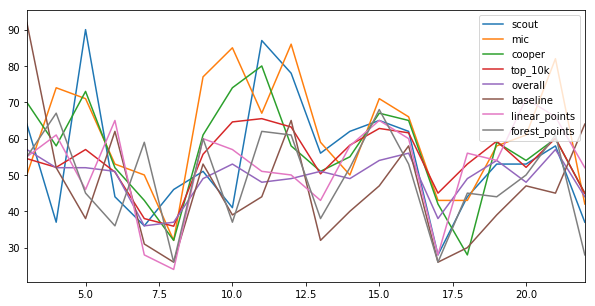

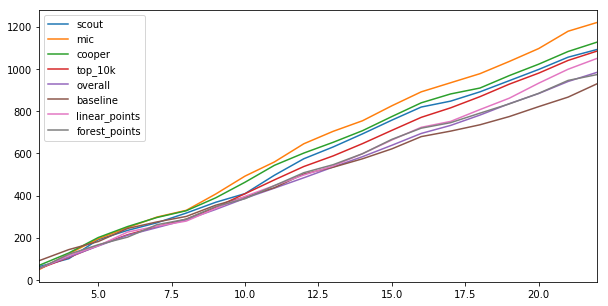

In [197]:
team_points.loc[3:].plot(figsize=(10,5))
team_points.loc[3:].cumsum().plot(figsize=(10,5))
team_points.loc[3:].sum()

In [205]:
print('number of times missing bench points baseline:', number_of_alerts_baseline)
print('number of times missing bench points linear:', number_of_alerts_forest)
print('number of times missing bench points forest:', number_of_alerts_forest)

number of times missing bench points baseline: 2
number of times missing bench points linear: 4
number of times missing bench points forest: 4
